!! Only run this code on the cluster !! OTHERWISE THINGS GO UP IN SMOKE

Calculate mean methylation of each TE in the genome

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_60462/2199209026.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  divergence_gff


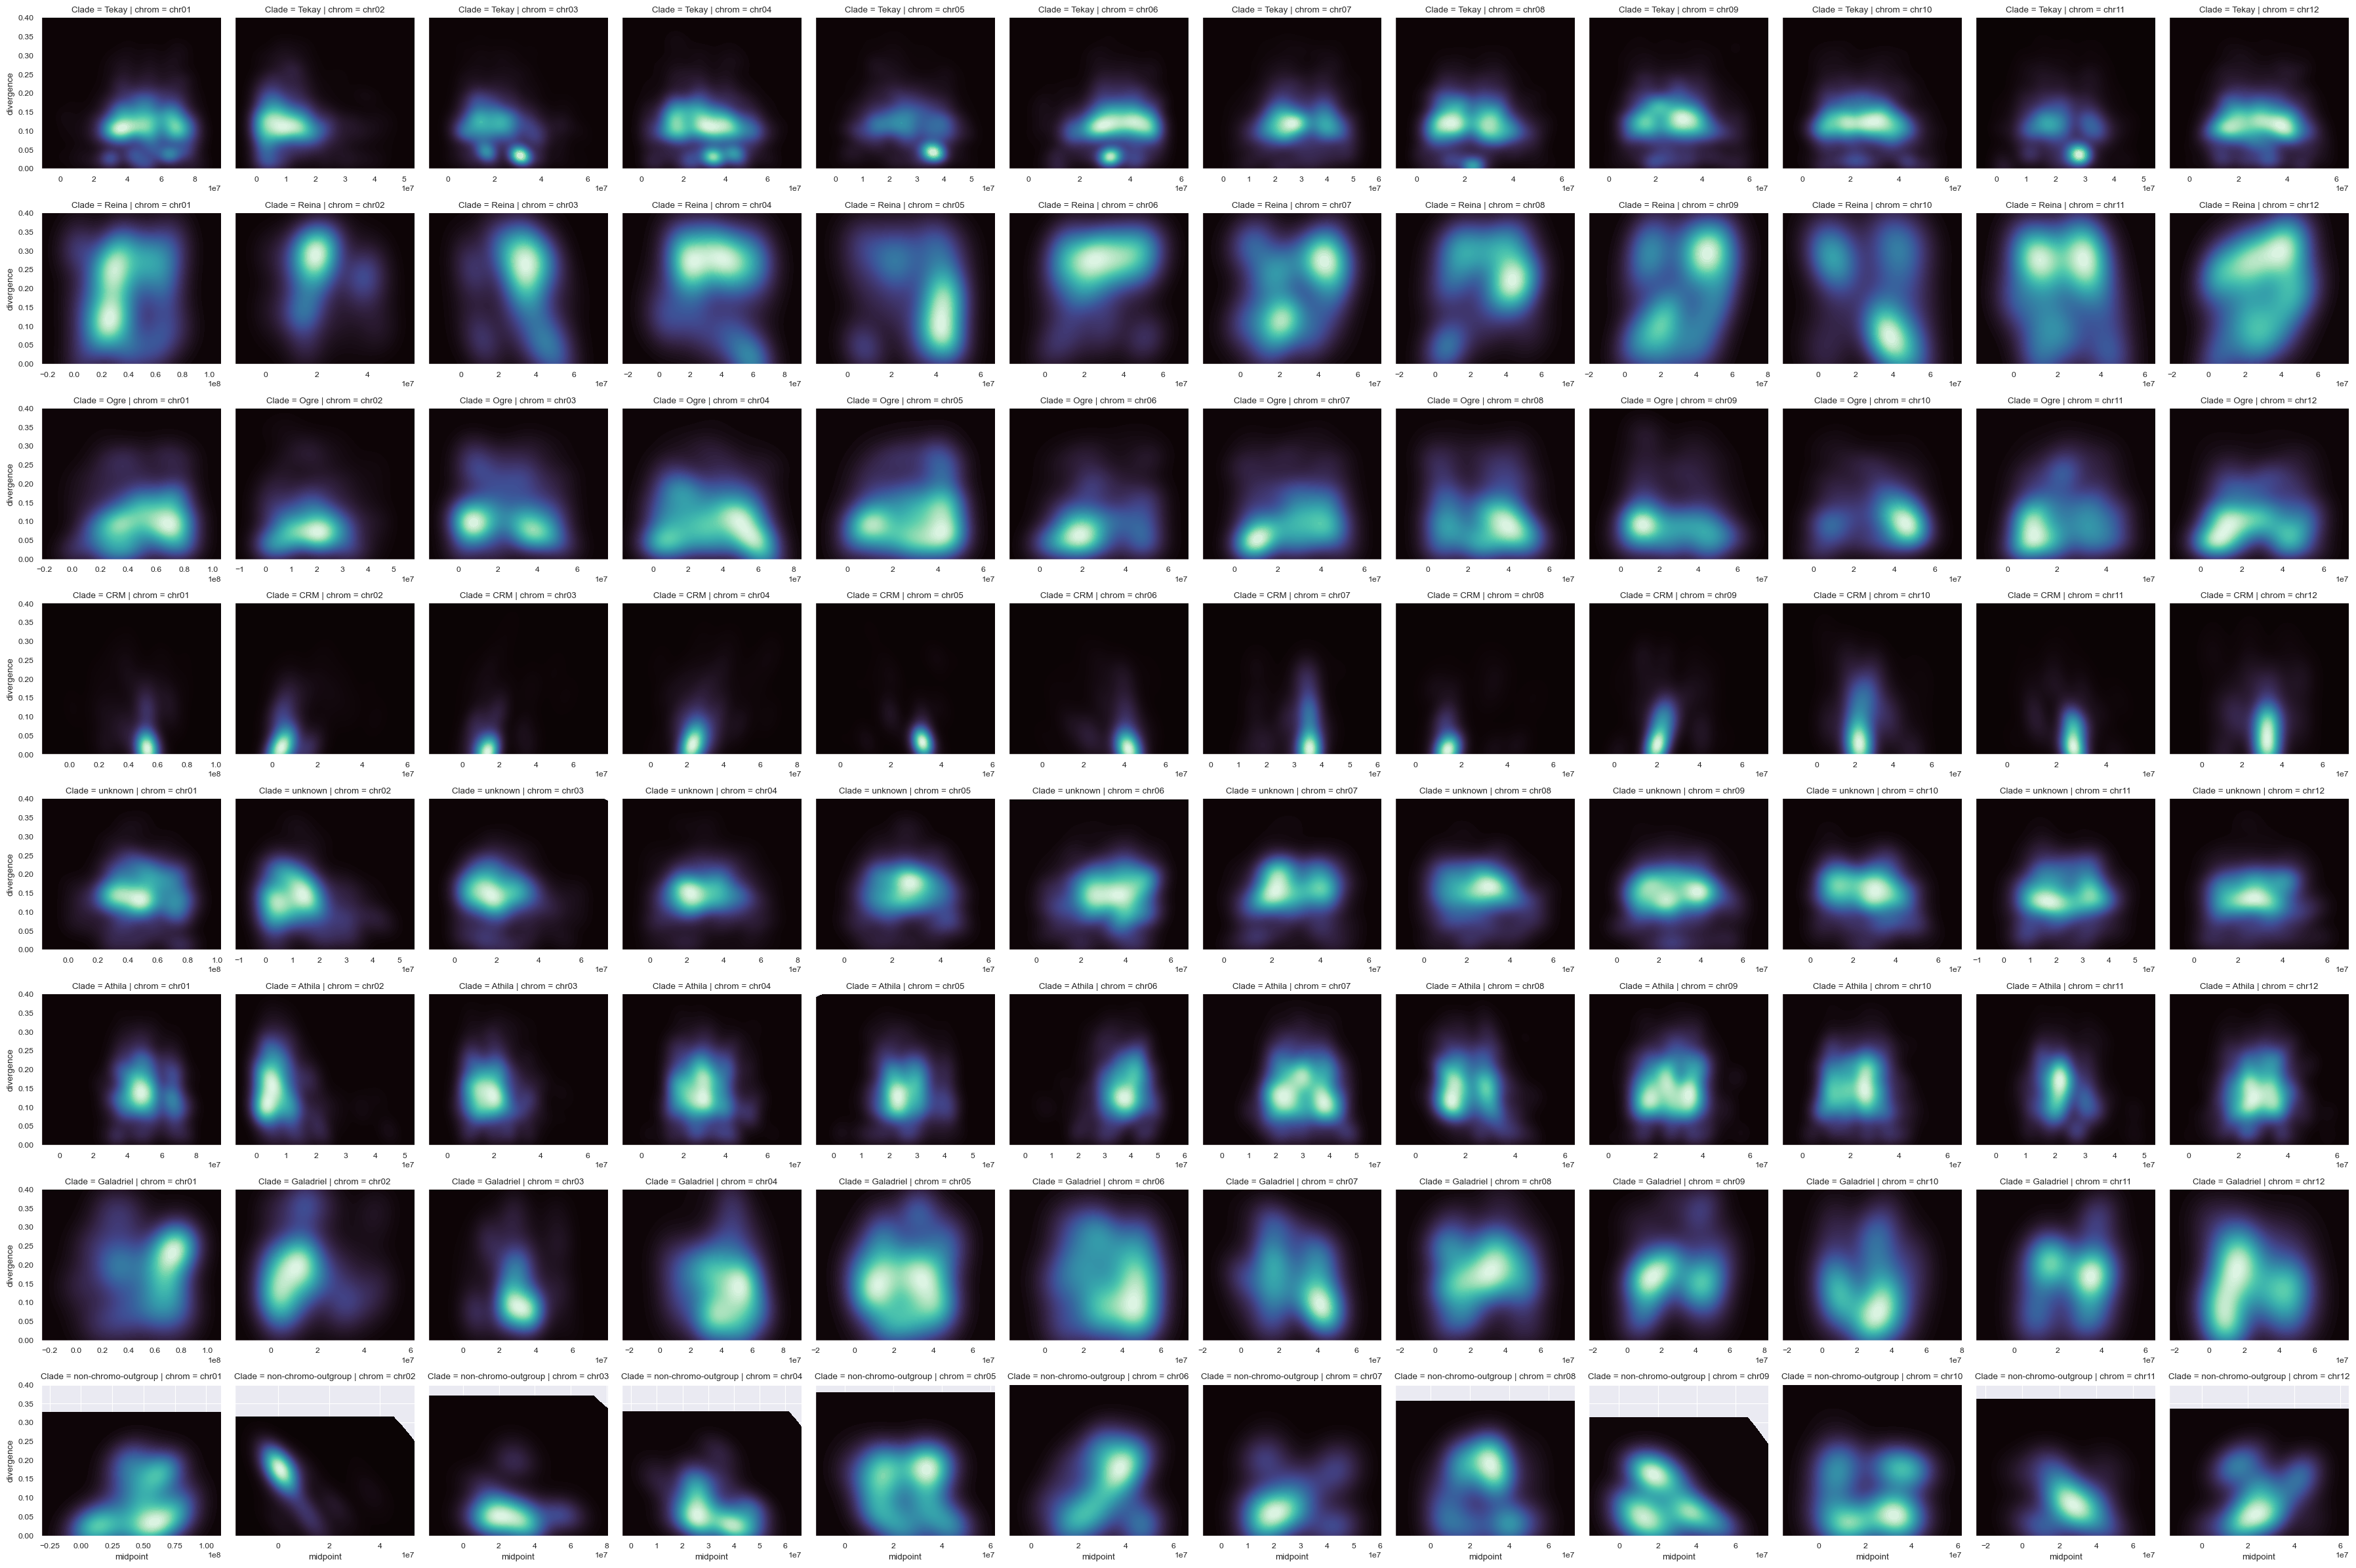

In [15]:
classified_divergence = (
    divergence_gff
    .select(chrom=pl.col("column_1"), start=pl.col("column_4"), end=pl.col("column_5"), family=pl.col("family"), divergence=pl.col("divergence"))
    .join(tesorter, on="family", how="left")
)

g = sns.FacetGrid(
    (
        classified_divergence
        .with_columns(
            ((pl.col("end") - pl.col("start"))/2 + pl.col("start")).alias("midpoint"),
            (pl.col("end") - pl.col("start")).alias("length"),
        )
        .filter(
            (pl.col("Superfamily") == "Gypsy") &
            (pl.col("chrom").str.contains("chr"))
        )
    ),
    col="chrom",
    row="Clade",
    sharex=False,
)
g.map_dataframe(
    sns.kdeplot,
    x="midpoint",
    y="divergence",
    weights="length",
    fill=True,
    thresh=0,
    levels=100,
    cmap="mako",
)
g.set(ylim=(0, 0.4))

Create a bed file of JUST CRM and Tekay elements. maybe even make it with colours!

In [154]:
CRM_families = (
    merged
    .filter(pl.col("Clade") == "CRM")
    .select("family")
    .to_series()
    .to_list()
)

Tekay_families = (
    merged
    .filter(pl.col("Clade") == "Tekay")
    .select("family")
    .to_series()
    .to_list()
)

crm_tekay_bed = (
    earlgrey_gff
    .filter(pl.col("family").is_in(CRM_families) | pl.col("family").is_in(Tekay_families))
    .with_columns(
        (
            pl
            .when(pl.col("family").is_in(CRM_families))
            .then(pl.lit("CRM"))
            .otherwise(pl.lit("Tekay"))
            .alias("Clade")
        ),
        pl.lit(0).alias("score"),
        pl.lit(".").alias("strand"),
        pl.col("column_4").alias("thickStart"),
        pl.col("column_5").alias("thickEnd"),
        (
            pl
            .when(pl.col("family").is_in(CRM_families))
            .then(pl.lit("0,0,255"))
            .otherwise(pl.lit("255,0,0"))
            .alias("itemRgb")
        )


    )
    .select(["column_1", "column_4", "column_5", "Clade", "score", "strand", "thickStart", "thickEnd", "itemRgb"])
)

crm_tekay_bed.write_csv("../results/crm_tekay.bed", separator = "\t", include_header = False)

In [180]:
# non-redundant blast hits of trash repeats against earlgrey library
blast_hits = (
    pl.read_csv(
        "../results/TRASH/trash_library.nr.blastn.earlgrey.txt",
        separator="\t",
        has_header=False,
    )
    .with_columns(
        pl.col("column_2").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 1).alias("family"),
    )
    .join(merged.select("family", "Clade"), on="family", how="inner")
    .filter(pl.col("Clade") != "NaN")
    .sort("column_12")
    .group_by("column_1")
    .agg(pl.first("Clade").alias("Clade"))
)

# Now we need to join this, not to the BED file from TRASH, but the "all repeats" file

all_repeats = (
    pl.read_csv(
        "../results/TRASH/all.repeats.from.final_assembly.fa.csv",
        separator=",",
        has_header=True,
    )
    .with_columns(
        (pl.col("seq.name") + ":" + pl.col("start").cast(pl.String) + "-" + pl.col("end").cast(pl.String)).alias("column_1"),
    )
)

sequence_to_clade = (
    blast_hits
    .join(all_repeats, on="column_1", how="inner")
    .select("seq", "Clade")
)

trash_bed = (
    all_repeats
    .join(sequence_to_clade, on="seq", how="inner")
    .select(["seq.name", "start", "end", "Clade"])
    .with_columns(
        pl.lit(0).alias("score"),
        pl.lit(".").alias("strand"),
        pl.col("start").alias("thickStart"),
        pl.col("end").alias("thickEnd"),
        (
            pl
            .when(pl.col("Clade") == "CRM")
            .then(pl.lit("0,0,255"))
            .when(pl.col("Clade") == "Tekay")
            .then(pl.lit("255,0,0"))
            .otherwise(pl.lit("0,0,0"))
            .alias("itemRgb")
        )
    )
)

trash_bed.write_csv("../results/trash.bed", separator="\t", include_header=False)